In [1]:
import pandas as pd
import torch
from einops import rearrange
from util import Keypoint, draw_bodypose
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import random
from util import create_image_grid_with_borders, draw_bodypose, translate_to_keyppoints
from torch.utils.data import Subset

In [2]:
VERSION = 'v5'
random.seed(42)
torch.manual_seed(123)

In [3]:
NECK = 1
def scale_pose(poses, scale):
    poses = poses.clone()
    meanx = poses[:, :, 0].mean(dim=1)
    meany = poses[:, :, 1].mean(dim=1)
    poses[:, :, 0] -= meanx.unsqueeze(1)
    poses[:, :, 1] -= meany.unsqueeze(1)
    poses[:, :, 0] *= scale[0]
    poses[:, :, 1] *= scale[1]
    poses[:, :, 0] += meanx.unsqueeze(1)
    poses[:, :, 1] += meany.unsqueeze(1)
    return poses

def calculate_relative_points(poses):
    res = poses.clone()
    res -= poses[:, NECK:NECK+1, :] # subtract neck
    return res

In [4]:
df = pd.read_csv('data/poses.csv')
df = df[~(df['class'].isin(['squat']))] # remove squats
df = df.drop('class', axis=1) # remove class column
df = df[~(df == 0).any(axis=1)] # remove rows with any zeros - undefined ponints
poses = torch.tensor(df.values, dtype=torch.float32) # convert to tensor
poses = rearrange(poses, 'n (ps p) -> n ps p', p=2) # rearrange to (n, 18, 2)
poses = scale_pose(poses, (1.75, 1.0)) # fix x-axis points
poses = calculate_relative_points(poses) # change to relative to NECK

# augument the dataset with scaling
get_scale = lambda : (random.betavariate(alpha=0.9, beta=1.1)) * 3.5 + 0.05
REPETITIONS = 2
res = []
for n in range(REPETITIONS):
    p1 = poses.clone()
    scale = torch.tensor([get_scale() for _ in range(p1.shape[0])], dtype=torch.float32).unsqueeze(1).unsqueeze(2)
    print(scale)
    p1 *= scale
    res.append(p1)
poses_scaled = torch.cat(res, dim=0)

# augument the dataset with x and y axis rotation
def rotate_both_axis(thetax: float, thetay: float):
    t = [
        [math.cos(thetay), math.sin(thetay)*math.sin(thetax)],
        [0, math.cos(thetax)]
    ]
    return t

ROTATION_REPETITIONS = 2
get_rotationy = lambda: (random.betavariate(alpha=2.5, beta=2.5) - 0.5) * np.pi / 2
get_rotationx = lambda: (random.betavariate(alpha=7, beta=7) - 0.5) * np.pi / 2
res = []
for n in range(ROTATION_REPETITIONS):
    matrices = torch.tensor([rotate_both_axis(get_rotationx(), get_rotationy()) for _ in range(poses_scaled.shape[0])], dtype=torch.float32)
    p1 = poses_scaled.clone()
    p1 = torch.matmul(p1, matrices)
    res.append(p1)
poses_scaled = torch.cat(res, dim=0)


# augument dataset based on x-scaling
get_scale = lambda : (random.betavariate(alpha=2, beta=2)) + 0.5
REPETITIONS = 1
res = []
for n in range(REPETITIONS):
    p1 = poses_scaled.clone()
    scale = torch.tensor([get_scale() for _ in range(p1.shape[0])], dtype=torch.float32).reshape(-1, 1)
    p1[:, :, 0] *= scale
    res.append(p1)
poses_scaled = torch.cat(res, dim=0)

# # add image ratios
nposes = poses_scaled.shape[0]
ratios = [1344/768, 1.0, 768/1344]
ratios_tensor = torch.cat([
    torch.ones(nposes, 1) * ratios[0],
    torch.ones(nposes, 1) * ratios[1],
    torch.ones(nposes, 1) * ratios[2],
], dim=0).squeeze()
res_scaled = []
for ratio in ratios:
    p1 = poses_scaled.clone()
    p1[:, :, 0] *= ratio
    res_scaled.append(p1)
poses_scaled = torch.cat(res_scaled, dim=0)

# augument the dataset with missing points
missing_conf = [
    [], # no missing
    [0] #missing nose
    [10, 13],
    [9, 10, 12, 13],
    [8, 9, 10, 11, 12, 13],
    [4,7,8,9,10,11,12,13],
    [4,7,9,10,12,13],
    [3,4,6,7,8,9,10,11,12,13],
    [7,9,10,12,13],
    [4,9,10,12,13],
    [7],
    [4],
    [6,7],
    [3,4],
    [10],
    [13],
    [16],
    [17],
    [14,16],
    [15,17],
    [14,15,16,17]
]
res_missing = []
res_scaled = []
for conf in missing_conf:
    # missing
    p1 = poses_scaled.clone()
    p1[:, conf, :] = -10.0
    res_missing.append(p1)
    # non missing
    p2 = poses_scaled.clone()
    res_scaled.append(p2)
poses_missing = torch.cat(res_missing, dim=0)
poses_scaled = torch.cat(res_scaled, dim=0)

# extend ratios tensor
n = poses_scaled.shape[0]
assert n % ratios_tensor.shape[0] == 0 # check if multiplier
k = n // ratios_tensor.shape[0]
assert len(missing_conf) == k
ratios_tensor = ratios_tensor.repeat(k)

tensor([[[2.3181]],

        [[2.4647]],

        [[0.4558]],

        ...,

        [[0.3523]],

        [[3.4302]],

        [[2.8538]]])
tensor([[[0.4383]],

        [[0.9985]],

        [[2.7797]],

        ...,

        [[0.6237]],

        [[0.8909]],

        [[2.7092]]])


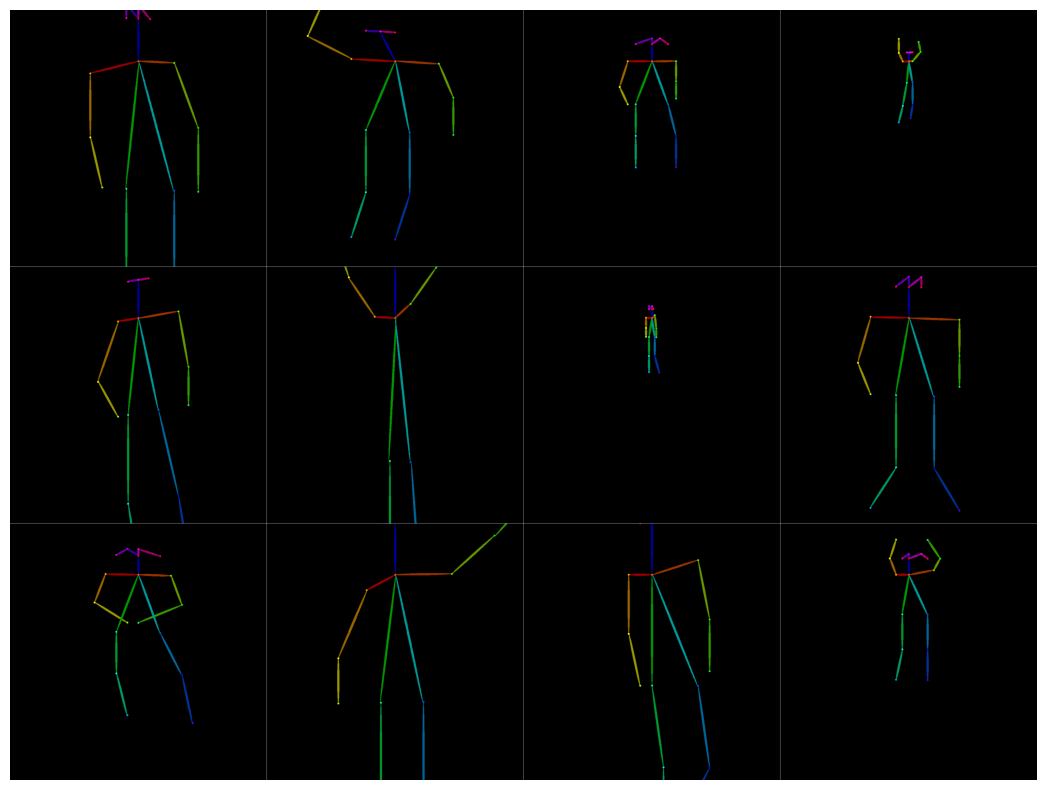

In [5]:
import random
h = 1024
w = 1024
images = [Image.fromarray(draw_bodypose(np.zeros((h, w, 3), dtype=np.uint8), 
                                        translate_to_keyppoints(poses_scaled[i].numpy(),leave_out_invisible=True), 
                                        translation=(0.5, 0.2),
                                         show_invisible=True )) 
          for i in random.sample(range(0, poses_scaled.shape[0] + 1), 12)]
rows = 3
cols = 4
grid_img = create_image_grid_with_borders(images, rows, cols)
fig = plt.figure(figsize=(14, 10))
plt.imshow(grid_img)
plt.axis('off')
plt.show();

In [6]:
poses_scaled_rearranged = rearrange(poses_scaled, 'n ps p -> n (ps p)')
poses_missing_rearranged = rearrange(poses_missing, 'n ps p -> n (ps p)')

In [7]:
# check if ratios and points are of the same length and 
# if missing and scaled are the same except for the missing points
print(poses_scaled_rearranged.shape, poses_missing_rearranged.shape, ratios_tensor.shape)
assert poses_scaled_rearranged.shape[0] == ratios_tensor.shape[0]
assert poses_scaled_rearranged.shape[0] == poses_missing_rearranged.shape[0]

assert poses_scaled_rearranged.shape[1] == poses_missing_rearranged.shape[1] == 36

mask = poses_missing_rearranged != -10.0
assert (poses_missing_rearranged[mask] == poses_scaled_rearranged[mask]).all()

torch.Size([353520, 36]) torch.Size([353520, 36]) torch.Size([353520])


In [8]:
data_dir = f'data/{VERSION}'
# split into train, validation aand test
total_size = poses_missing_rearranged.shape[0]
train_size = int(0.7 * total_size)
valid_size = int(0.15 * total_size)

# Create indices for train, validation, test
indices = torch.randperm(total_size).tolist()
train_indices = indices[:train_size]
valid_indices = indices[train_size:train_size+valid_size]
test_indices = indices[train_size+valid_size:]

os.makedirs(data_dir, exist_ok=True)

# save shuffled data
torch.save(poses_scaled_rearranged[train_indices], os.path.join(data_dir, 'poses_train.pt'))
torch.save(poses_scaled_rearranged[valid_indices], os.path.join(data_dir, 'poses_valid.pt'))
torch.save(poses_scaled_rearranged[test_indices], os.path.join(data_dir, 'poses_test.pt'))
torch.save(poses_missing_rearranged[train_indices], os.path.join(data_dir, 'poses_missing_train.pt'))
torch.save(poses_missing_rearranged[valid_indices], os.path.join(data_dir, 'poses_missing_valid.pt'))
torch.save(poses_missing_rearranged[test_indices], os.path.join(data_dir, 'poses_missing_test.pt'))
# torch.save(ratios_tensor[train_indices], os.path.join(data_dir, 'ratios_train.pt'))
# torch.save(ratios_tensor[valid_indices], os.path.join(data_dir, 'ratios_valid.pt'))
# torch.save(ratios_tensor[test_indices], os.path.join(data_dir, 'ratios_test.pt'))

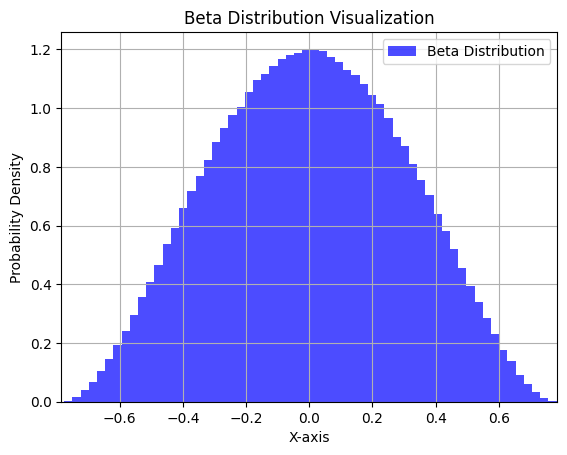

In [321]:
import matplotlib.pyplot as plt
import random

# Parameters of the Beta distribution
alpha = 3  # Alpha parameter
beta = 3 # Beta parameter
num_samples = 1000000  # Number of samples to generate

# Generate random samples from the Beta distribution

samples = [(random.betavariate(alpha, beta) - 0.5) * np.pi / 2  for _ in range(num_samples)]

# Create a histogram of the generated samples
plt.hist(samples, bins=60, density=True, alpha=0.7, color='blue', label='Beta Distribution')

# Add labels and a legend
plt.xlabel('X-axis')
plt.ylabel('Probability Density')
# add left and right limit on x axis
plt.xlim(left=-np.pi/4, right=np.pi/4)
plt.legend(loc='best')

# Show the plot
plt.title('Beta Distribution Visualization')
plt.grid(True)
plt.show()
